In [2]:
import torch

import torch.nn as nn

import torch.optim as optim

from torch.optim import lr_scheduler

import numpy as np

import torchvision

from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt

import time

import os

import copy



mean = np.array([0.5, 0.5, 0.5])

std = np.array([0.25, 0.25, 0.25])



data_transforms = {

    'train': transforms.Compose([

        transforms.RandomResizedCrop(224),

        transforms.RandomHorizontalFlip(),

        transforms.ToTensor(),

        transforms.Normalize(mean, std)

    ]),

    'val': transforms.Compose([

        transforms.Resize(256),

        transforms.CenterCrop(224),

        transforms.ToTensor(),

        transforms.Normalize(mean, std)

    ]),

}

In [ ]:
data_dir = '/home/foe_stu/Documents/DATA/trainPhase4/data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),

                                          data_transforms[x])

                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=2,

                                             shuffle=True, num_workers=0)

              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(class_names)





def imshow(inp, title):

    """Imshow for Tensor."""

    inp = inp.numpy().transpose((1, 2, 0))

    inp = std * inp + mean

    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)

    plt.title(title)

    plt.show()



['Obs', 'def', 'nor']


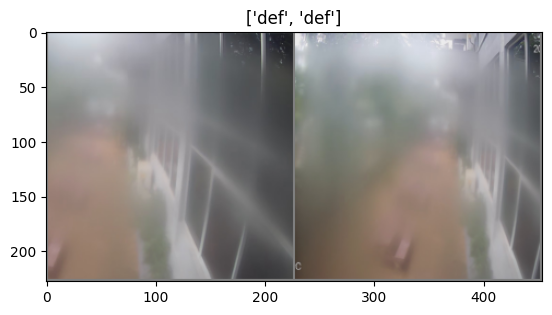

In [7]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

# Get a batch of training data

inputs, classes = next(iter(dataloaders['train']))



# Make a grid from batch

out = torchvision.utils.make_grid(inputs)



imshow(out, title=[class_names[x] for x in classes])



def train_model(model, criterion, optimizer, scheduler, num_epochs=25):

    since = time.time()



    best_model_wts = copy.deepcopy(model.state_dict())

    best_acc = 0.0



    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        print('-' * 10)



        # Each epoch has a training and validation phase

        for phase in ['train', 'val']:

            if phase == 'train':

                model.train()  # Set model to training mode

            else:

                model.eval()   # Set model to evaluate mode



            running_loss = 0.0

            running_corrects = 0



            # Iterate over data.

            for inputs, labels in dataloaders[phase]:

                inputs = inputs.to(device)

                labels = labels.to(device)



                # forward

                # track history if only in train

                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(inputs)

                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)



                    # backward + optimize only if in training phase

                    if phase == 'train':

                        optimizer.zero_grad()

                        loss.backward()

                        optimizer.step()



                # statistics

                running_loss += loss.item() * inputs.size(0)

                running_corrects += torch.sum(preds == labels.data)



            if phase == 'train':

                scheduler.step()



            epoch_loss = running_loss / dataset_sizes[phase]

            epoch_acc = running_corrects.double() / dataset_sizes[phase]



            print('{} Loss: {:.4f} Acc: {:.4f}'.format(

                phase, epoch_loss, epoch_acc))
            
            train_loss.append(epoch_loss)
            train_acc.append(epoch_acc)



            # deep copy the model

            if phase == 'val' and epoch_acc > best_acc:

                best_acc = epoch_acc

                best_model_wts = copy.deepcopy(model.state_dict())
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)



        print()



    time_elapsed = time.time() - since

    print('Training complete in {:.0f}m {:.0f}s'.format(

        time_elapsed // 60, time_elapsed % 60))

    print('Best val Acc: {:4f}'.format(best_acc))



    # load best model weights

    model.load_state_dict(best_model_wts)

    return model



In [8]:
model = models.mobilenet_v2(pretrained=True)
num_classes = 3

# Replace the final classifier with a new one
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.2),  # Add dropout if needed
    torch.nn.Linear(model.last_channel, num_classes),
)
print(model)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [9]:


model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)



In [10]:


model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=40)

 

Epoch 0/39
----------
train Loss: 0.5689 Acc: 0.7629
val Loss: 0.0159 Acc: 0.9995

Epoch 1/39
----------
train Loss: 0.4103 Acc: 0.8370
val Loss: 0.0621 Acc: 0.9892

Epoch 2/39
----------
train Loss: 0.1866 Acc: 0.9380
val Loss: 0.3207 Acc: 0.8949

Epoch 3/39
----------
train Loss: 0.1034 Acc: 0.9661
val Loss: 0.2538 Acc: 0.9262

Epoch 4/39
----------
train Loss: 0.0750 Acc: 0.9756
val Loss: 0.0795 Acc: 0.9652

Epoch 5/39
----------
train Loss: 0.0641 Acc: 0.9780
val Loss: 0.0158 Acc: 0.9987

Epoch 6/39
----------
train Loss: 0.0617 Acc: 0.9796
val Loss: 0.0598 Acc: 0.9786

Epoch 7/39
----------
train Loss: 0.0405 Acc: 0.9880
val Loss: 0.0338 Acc: 0.9918

Epoch 8/39
----------
train Loss: 0.0350 Acc: 0.9889
val Loss: 0.0349 Acc: 0.9872

Epoch 9/39
----------
train Loss: 0.0335 Acc: 0.9902
val Loss: 0.0515 Acc: 0.9880

Epoch 10/39
----------
train Loss: 0.0333 Acc: 0.9895
val Loss: 0.0555 Acc: 0.9828

Epoch 11/39
----------
train Loss: 0.0290 Acc: 0.9904
val Loss: 0.0403 Acc: 0.9871

Ep

In [11]:
# Assuming 'model' is your PyTorch model

torch.save(model.state_dict(), 'mobilenetP4.pth')

torch.save(optimizer.state_dict(), "mobilenetoptimP4.pth")


(0.762941557470978, 0.999474030243261, 0.8370285486522844, 0.9892176199868508, 0.9379702057695182, 0.8949375410913872, 0.9661202730307409, 0.926232741617357, 0.975586667330975, 0.965154503616042, 0.9779781774699815, 0.9986850756081525, 0.9795725175626525, 0.9785667324128863, 0.9879926261770714, 0.9918474687705456, 0.9888894424791989, 0.9872452333990795, 0.990184843804494, 0.988034188034188, 0.9894873200139505, 0.9827744904667981, 0.9904339594439738, 0.9871137409598948, 0.9907328982113497, 0.9738330046022353, 0.9904339594439738, 0.9921104536489151, 0.9919784764087489, 0.9725180802103879, 0.9914802451297893, 0.9805391190006574, 0.9903841363160779, 0.9626561472715318, 0.9917293607692691, 0.9364891518737672, 0.991928653280853, 0.9738330046022353, 0.9917293607692691, 0.9714661406969098, 0.9913805988739973, 0.9780407626561473, 0.991779183897165, 0.9851413543721236, 0.9904339594439738, 0.9780407626561473, 0.9915300682576852, 0.9794871794871794, 0.9920781226645409, 0.9827744904667981, 0.991679

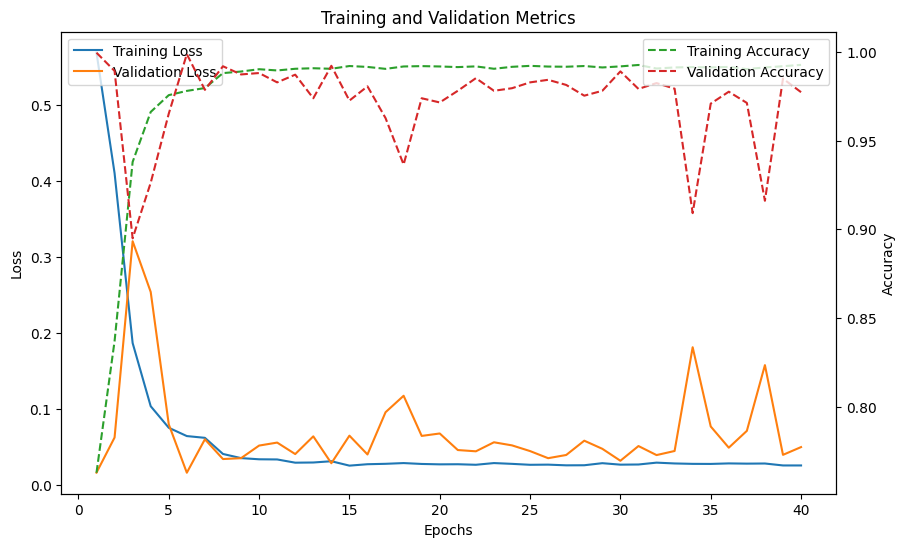

In [12]:
tensor_tuple = train_acc

# Extract the first element of each tensor in the tuple
float_tuple = tuple(tensor.item() for tensor in tensor_tuple)

# Print the float tuple
print(float_tuple)


def separate_even_odd_indexes(float_tuple):
  train_accuracy = tuple(ele for idx, ele in enumerate(float_tuple) if idx % 2 == 0)
  valid_accuracy = tuple(ele for idx, ele in enumerate(float_tuple) if idx % 2 != 0)
  return train_accuracy, valid_accuracy

#test_tup = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
train_accuracyy, valid_accuracyy = separate_even_odd_indexes(float_tuple)


#Losses
def separate_even_odd_indexes(train_loss):
  trainig_loss = tuple(ele for idx, ele in enumerate(train_loss) if idx % 2 == 0)
  val_loss = tuple(ele for idx, ele in enumerate(train_loss) if idx % 2 != 0)
  return trainig_loss, val_loss

#test_tup = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
trainig_loss, val_loss = separate_even_odd_indexes(train_loss)

print(trainig_loss)
print(val_loss)

import matplotlib.pyplot as plt




# Sample data (replace with your actual data)

epochs = [1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40]

train_losses = trainig_loss

val_losses = val_loss

train_accuracies = train_accuracyy

val_accuracies = valid_accuracyy



fig, ax1 = plt.subplots(figsize=(10, 6))



# Plot training and validation losses on the primary y-axis (left)

ax1.plot(epochs, train_losses, label='Training Loss', color='tab:blue')

ax1.plot(epochs, val_losses, label='Validation Loss', color='tab:orange')

ax1.set_xlabel('Epochs')

ax1.set_ylabel('Loss', color='black')

ax1.tick_params(axis='y', labelcolor='black')

ax1.legend(loc='upper left')



# Create a secondary y-axis (right) for accuracy

ax2 = ax1.twinx()



# Plot training and validation accuracies on the secondary y-axis (right)

ax2.plot(epochs, train_accuracies, label='Training Accuracy', linestyle='--', color='tab:green')

ax2.plot(epochs, val_accuracies, label='Validation Accuracy', linestyle='--', color='tab:red')

ax2.set_ylabel('Accuracy', color='black')

ax2.tick_params(axis='y', labelcolor='black')

ax2.legend(loc='upper right')



plt.title('Training and Validation Metrics')

plt.xlabel('Epochs')



# Show the combined plot

plt.show()

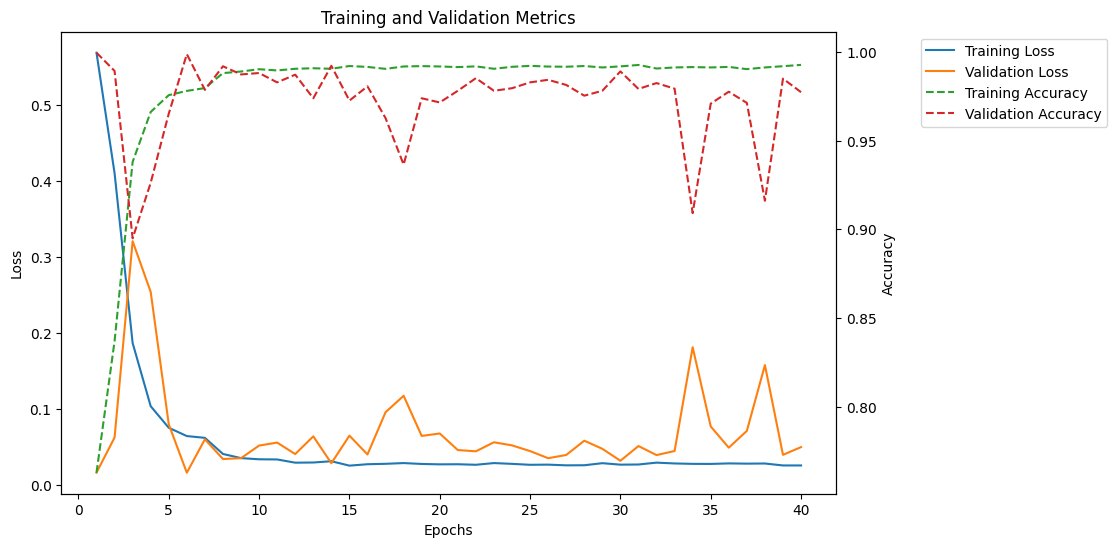

In [13]:
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
epochs = [1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40]
train_losses = trainig_loss
val_losses = val_loss
train_accuracies = train_accuracyy
val_accuracies = valid_accuracyy

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot training and validation losses on the primary y-axis (left)
ax1.plot(epochs, train_losses, label='Training Loss', color='tab:blue')
ax1.plot(epochs, val_losses, label='Validation Loss', color='tab:orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a secondary y-axis (right) for accuracy
ax2 = ax1.twinx()

# Plot training and validation accuracies on the secondary y-axis (right)
ax2.plot(epochs, train_accuracies, label='Training Accuracy', linestyle='--', color='tab:green')
ax2.plot(epochs, val_accuracies, label='Validation Accuracy', linestyle='--', color='tab:red')
ax2.set_ylabel('Accuracy', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Place the legend outside the graph
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper left', bbox_to_anchor=(1.1, 1.0))

plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')

# Show the combined plot
plt.show()
